In [1]:
using Flux, ParameterSchedulers, Optimisers, Statistics, CUDA 
using Flux: Conv, BatchNorm, MaxPool, flatten, Dense, Dropout, relu, softmax
using Base.Iterators: repeated, partition
using Printf, BSON, JLD2, LinearAlgebra
using ImageCore, Images
using MLDatasets: convert2image, CIFAR10
using Plots              
using StatsBase

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\oliwi\.julia\packages\Flux\9PibT\ext\FluxCUDAExt\FluxCUDAExt.jl:10


In [2]:
ENV["DATADEPS_ALWAYS_ACCEPT"] = "true"

"true"

In [3]:
use_cuda = true

true

In [4]:
if use_cuda && CUDA.functional()
    device = gpu
    @info "Training on GPU"
else
    device = cpu
    @info "Training on CPU"
end

┌ Info: Training on CPU
└ @ Main c:\Users\oliwi\Desktop\SGH\masgisterka\II_sem\Deep Learning\projekt_zaliczeniowy\DeepLearningProjektZaliczeniowy\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W3sZmlsZQ==.jl:6


In [5]:
function make_minibatch(X, Y, idxs)
    X_batch = Array{Float32}(undef, 32, 32, 3, length(idxs))
    for (i, idx) in enumerate(idxs)
        X_batch[:,:,:,i] = X[:,:,:,idx]
    end
    Y_batch = Flux.onehotbatch(Y[idxs], 0:9)
    return X_batch, Y_batch
end

make_minibatch (generic function with 1 method)

In [6]:
test_set = CIFAR10(:test)
test_set = make_minibatch(test_set.features, test_set.targets, 1:size(test_set.features)[4]) |> device

(Float32[0.61960787 0.59607846 … 0.23921569 0.21176471; 0.62352943 0.5921569 … 0.19215687 0.21960784; … ; 0.49411765 0.49019608 … 0.11372549 0.13333334; 0.45490196 0.46666667 … 0.078431375 0.08235294;;; 0.4392157 0.4392157 … 0.45490196 0.41960785; 0.43529412 0.43137255 … 0.4 0.4117647; … ; 0.35686275 0.35686275 … 0.32156864 0.32941177; 0.33333334 0.34509805 … 0.2509804 0.2627451;;; 0.19215687 0.2 … 0.65882355 0.627451; 0.18431373 0.15686275 … 0.5803922 0.58431375; … ; 0.14117648 0.1254902 … 0.49411765 0.5058824; 0.12941177 0.13333334 … 0.41960785 0.43137255;;;; 0.92156863 0.93333334 … 0.32156864 0.33333334; 0.90588236 0.92156863 … 0.18039216 0.24313726; … ; 0.9137255 0.9254902 … 0.7254902 0.7058824; 0.9098039 0.92156863 … 0.73333335 0.7294118;;; 0.92156863 0.93333334 … 0.3764706 0.39607844; 0.90588236 0.92156863 … 0.22352941 0.29411766; … ; 0.9137255 0.9254902 … 0.78431374 0.7647059; 0.9098039 0.92156863 … 0.7921569 0.78431374;;; 0.92156863 0.93333334 … 0.32156864 0.3254902; 0.90588236

In [7]:
model_small_convnet = Chain(
  # — blok 1: 32×32 → 16×16, kanały 3 → 16 —
  Conv((3,3), 3=>16, pad=1), BatchNorm(16), relu,
  MaxPool((2,2)),                           # 16×16

  # — blok 2: 16×16 → 8×8, kanały 16 → 32 —
  Conv((3,3), 16=>32, pad=1), BatchNorm(32), relu,
  MaxPool((2,2)),                           # 8×8

  # — blok 3: 8×8 → 4×4, kanały 32 → 64 —
  Conv((3,3), 32=>64, pad=1), BatchNorm(64), relu,
  MaxPool((2,2)),                           # 4×4

  # — flatten + head FC —
  flatten,                                  # 64*4*4 = 1024
  Dense(1024, 128), relu, Dropout(0.5),
  Dense(128,   10),
  softmax
) |> device

BSON.@load "model_small_convnet.bson" ps

Flux.loadmodel!(model_small_convnet, device(ps))

Chain(
  Conv((3, 3), 3 => 16, pad=1),         # 448 parameters
  BatchNorm(16),                        # 32 parameters, plus 32
  NNlib.relu,
  MaxPool((2, 2)),
  Conv((3, 3), 16 => 32, pad=1),        # 4_640 parameters
  BatchNorm(32),                        # 64 parameters, plus 64
  NNlib.relu,
  MaxPool((2, 2)),
  Conv((3, 3), 32 => 64, pad=1),        # 18_496 parameters
  BatchNorm(64),                        # 128 parameters, plus 128
  NNlib.relu,
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(1024 => 128),                   # 131_200 parameters
  NNlib.relu,
  Dropout(0.5),
  Dense(128 => 10),                     # 1_290 parameters
  NNlib.softmax,
)         # Total: 16 trainable arrays, 156_298 parameters,
          # plus 6 non-trainable, 224 parameters, summarysize 613.047 KiB.

In [56]:
struct ResBlock
  f::Chain
end

function ResBlock(channels::Integer)
  return ResBlock(Chain(
    Conv((3,3), channels=>channels, pad=1),
    BatchNorm(channels), relu,
    Conv((3,3), channels=>channels, pad=1),
    BatchNorm(channels)
  ))
end

# aplikacja bloku: F(x)+x, potem ReLU
(m::ResBlock)(x) = relu(m.f(x) .+ x)

model_resNet = Chain(
  # Block 1: 3→32
  Conv((3,3), 3=>32, pad=1), BatchNorm(32), relu,
  ResBlock(32),
  MaxPool((2,2)),      # 32×32 → 16×16

  # Block 2: 32→64
  Conv((3,3), 32=>64, pad=1), BatchNorm(64), relu,
  ResBlock(64),
  MaxPool((2,2)),      # 16×16 → 8×8

  # Flatten i head
  flatten,             # 64*8*8 = 4096
  Dense(4096, 128),    BatchNorm(128), relu, Dropout(0.5),
  Dense(128, 10),
  softmax
) |> device

BSON.@load "model_resNet.bson" ps

Flux.loadmodel!(model_resNet, device(ps))

Chain(
  Conv((3, 3), 3 => 32, pad=1),         # 896 parameters
  BatchNorm(32),                        # 64 parameters, plus 64
  NNlib.relu,
  ResBlock(
    Chain(
      Conv((3, 3), 32 => 32, pad=1),    # 9_248 parameters
      BatchNorm(32),                    # 64 parameters, plus 64
      NNlib.relu,
      Conv((3, 3), 32 => 32, pad=1),    # 9_248 parameters
      BatchNorm(32),                    # 64 parameters, plus 64
    ),
  ),
  MaxPool((2, 2)),
  Conv((3, 3), 32 => 64, pad=1),        # 18_496 parameters
  BatchNorm(64),                        # 128 parameters, plus 128
  NNlib.relu,
  ResBlock(
    Chain(
      Conv((3, 3), 64 => 64, pad=1),    # 36_928 parameters
      BatchNorm(64),                    # 128 parameters, plus 128
      NNlib.relu,
      Conv((3, 3), 64 => 64, pad=1),    # 36_928 parameters
      BatchNorm(64),                    # 128 parameters, plus 128
    ),
  ),
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(4096 => 128),                   # 524_416 para

In [57]:
model_vgg = Chain(
  # --- blok 1: 3 → 64 ---
  Conv((3,3), 3=>64, pad=1), relu,
  Conv((3,3), 64=>64, pad=1), relu,
  MaxPool((2,2)),               # 32×32 → 16×16

  # --- blok 2: 64 → 128 ---
  Conv((3,3), 64=>128, pad=1), relu,
  Conv((3,3), 128=>128, pad=1), relu,
  MaxPool((2,2)),               # 16×16 → 8×8

  # --- blok 3: 128 → 256 ---
  Conv((3,3), 128=>256, pad=1), relu,
  Conv((3,3), 256=>256, pad=1), relu,
  MaxPool((2,2)),               # 8×8 → 4×4

  # spłaszczamy
  flatten,                      # 256×4×4 = 4096

  # --- klasyfikator ---
  Dense(4096, 512), relu, Dropout(0.5),
  Dense(512, 256), relu, Dropout(0.5),
  Dense(256, 10),
  softmax
) |> device

BSON.@load "model_vgg.bson" ps

Flux.loadmodel!(model_vgg, device(ps))

Chain(
  Conv((3, 3), 3 => 64, pad=1),         # 1_792 parameters
  NNlib.relu,
  Conv((3, 3), 64 => 64, pad=1),        # 36_928 parameters
  NNlib.relu,
  MaxPool((2, 2)),
  Conv((3, 3), 64 => 128, pad=1),       # 73_856 parameters
  NNlib.relu,
  Conv((3, 3), 128 => 128, pad=1),      # 147_584 parameters
  NNlib.relu,
  MaxPool((2, 2)),
  Conv((3, 3), 128 => 256, pad=1),      # 295_168 parameters
  NNlib.relu,
  Conv((3, 3), 256 => 256, pad=1),      # 590_080 parameters
  NNlib.relu,
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(4096 => 512),                   # 2_097_664 parameters
  NNlib.relu,
  Dropout(0.5),
  Dense(512 => 256),                    # 131_328 parameters
  NNlib.relu,
  Dropout(0.5),
  Dense(256 => 10),                     # 2_570 parameters
  NNlib.softmax,
)                   # Total: 18 arrays, 3_376_970 parameters, 12.884 MiB.

In [58]:
model_allcnn = Chain(
  # -- blok 1 --
  Conv((3,3), 3=>96, pad=1), relu,
  Conv((3,3), 96=>96, pad=1), relu,
  Conv((3,3), 96=>96, stride=2, pad=1), relu,   # downsample 32→16

  # -- blok 2 --
  Conv((3,3), 96=>192, pad=1), relu,
  Conv((3,3), 192=>192, pad=1), relu,
  Conv((3,3), 192=>192, stride=2, pad=1), relu, # downsample 16→8

  # -- blok 3 (klasyfikator) --
  Conv((3,3), 192=>192, pad=1), relu,
  Conv((1,1), 192=>192, pad=0), relu,
  Conv((1,1), 192=>10,  pad=0),              # mapujemy do 10 kanałów

  # -- global average pooling + softmax --
  x -> mean(x, dims=(1,2)),  # (10×1×1×N)
  flatten,                   # → (10, N)
  softmax
) |> device

BSON.@load "model_allcnn.bson" ps

Flux.loadmodel!(model_allcnn, device(ps))

Chain(
  Conv((3, 3), 3 => 96, pad=1),         # 2_688 parameters
  NNlib.relu,
  Conv((3, 3), 96 => 96, pad=1),        # 83_040 parameters
  NNlib.relu,
  Conv((3, 3), 96 => 96, pad=1, stride=2),  # 83_040 parameters
  NNlib.relu,
  Conv((3, 3), 96 => 192, pad=1),       # 166_080 parameters
  NNlib.relu,
  Conv((3, 3), 192 => 192, pad=1),      # 331_968 parameters
  NNlib.relu,
  Conv((3, 3), 192 => 192, pad=1, stride=2),  # 331_968 parameters
  NNlib.relu,
  Conv((3, 3), 192 => 192, pad=1),      # 331_968 parameters
  NNlib.relu,
  Conv((1, 1), 192 => 192),             # 37_056 parameters
  NNlib.relu,
  Conv((1, 1), 192 => 10),              # 1_930 parameters
  var"#16#17"(),
  Flux.flatten,
  NNlib.softmax,
)                   # Total: 18 arrays, 1_369_738 parameters, 5.227 MiB.

In [8]:
X_test, Y_test = test_set 

(Float32[0.61960787 0.59607846 … 0.23921569 0.21176471; 0.62352943 0.5921569 … 0.19215687 0.21960784; … ; 0.49411765 0.49019608 … 0.11372549 0.13333334; 0.45490196 0.46666667 … 0.078431375 0.08235294;;; 0.4392157 0.4392157 … 0.45490196 0.41960785; 0.43529412 0.43137255 … 0.4 0.4117647; … ; 0.35686275 0.35686275 … 0.32156864 0.32941177; 0.33333334 0.34509805 … 0.2509804 0.2627451;;; 0.19215687 0.2 … 0.65882355 0.627451; 0.18431373 0.15686275 … 0.5803922 0.58431375; … ; 0.14117648 0.1254902 … 0.49411765 0.5058824; 0.12941177 0.13333334 … 0.41960785 0.43137255;;;; 0.92156863 0.93333334 … 0.32156864 0.33333334; 0.90588236 0.92156863 … 0.18039216 0.24313726; … ; 0.9137255 0.9254902 … 0.7254902 0.7058824; 0.9098039 0.92156863 … 0.73333335 0.7294118;;; 0.92156863 0.93333334 … 0.3764706 0.39607844; 0.90588236 0.92156863 … 0.22352941 0.29411766; … ; 0.9137255 0.9254902 … 0.78431374 0.7647059; 0.9098039 0.92156863 … 0.7921569 0.78431374;;; 0.92156863 0.93333334 … 0.32156864 0.3254902; 0.90588236

In [9]:
function loss(model, x, y, device = device)
    x = x |>cpu
    x_aug = x .+ 0.1f0*randn(eltype(x), size(x)) |> device
    y_hat = model(x_aug)
    return Flux.crossentropy(y_hat, y) 
end

loss (generic function with 2 methods)

In [10]:
loss(model_small_convnet, test_set[1],test_set[2])

0.8666772f0

In [ ]:
# function loss_batched(model, X, Y; batchsize=64)
#   total_loss = 0f0
#   total_n    = 0
#   N = size(X, 4)
#   for i in 1:batchsize:N
#     j = min(i+batchsize-1, N)
#     xb = device(X[:,:,:, i:j])
#     yb = device(Y[:,   i:j])
#     # 1) oblicz stratę na batchu
#     l = Flux.crossentropy(model(xb), yb)
#     # 2) sumuj stratę ważoną liczbą próbek
#     nb = size(xb, 4)
#     total_loss += l * nb
#     total_n    += nb
#   end
#   return total_loss / total_n
# end

loss_batched (generic function with 1 method)

In [11]:
# loss_batched(model_small_convnet, X_test, Y_test; batchsize=64)

In [12]:
accuracy(model,x, y) = mean(Flux.onecold(model(x)) .== Flux.onecold(y))

accuracy (generic function with 1 method)

In [13]:
accuracy(model_small_convnet,test_set[1],test_set[2])

0.7007

In [59]:
models = [
  ("SmallConvNet",  model_small_convnet),
  ("ResNet",        model_resNet),
  ("VGG",           model_vgg),
  ("AllCNN",        model_allcnn),
]

4-element Vector{Tuple{String, Chain}}:
 ("SmallConvNet", Chain(Conv((3, 3), 3 => 16, pad=1), BatchNorm(16), relu, MaxPool((2, 2)), Conv((3, 3), 16 => 32, pad=1), BatchNorm(32), relu, MaxPool((2, 2)), Conv((3, 3), 32 => 64, pad=1), BatchNorm(64), relu, MaxPool((2, 2)), flatten, Dense(1024 => 128), relu, Dropout(0.5), Dense(128 => 10), softmax))
 ("ResNet", Chain(Conv((3, 3), 3 => 32, pad=1), BatchNorm(32), relu, ResBlock(Chain(Conv((3, 3), 32 => 32, pad=1), BatchNorm(32), relu, Conv((3, 3), 32 => 32, pad=1), BatchNorm(32))), MaxPool((2, 2)), Conv((3, 3), 32 => 64, pad=1), BatchNorm(64), relu, ResBlock(Chain(Conv((3, 3), 64 => 64, pad=1), BatchNorm(64), relu, Conv((3, 3), 64 => 64, pad=1), BatchNorm(64))), MaxPool((2, 2)), flatten, Dense(4096 => 128), BatchNorm(128), relu, Dropout(0.5), Dense(128 => 10), softmax))
 ("VGG", Chain(Conv((3, 3), 3 => 64, pad=1), relu, Conv((3, 3), 64 => 64, pad=1), relu, MaxPool((2, 2)), Conv((3, 3), 64 => 128, pad=1), relu, Conv((3, 3), 128 => 128, pad=1),

In [60]:
@printf("%-15s  %s\n", "Model", "Accuracy")
for (name, m) in models
    acc = accuracy(m, X_test, Y_test)
    @printf("%-15s  %5.2f%%\n", name, 100*acc)
end

Model            Accuracy
SmallConvNet     70.07%
ResNet           75.84%
VGG              74.56%


OutOfMemoryError: OutOfMemoryError()

In [ ]:
# function accuracy_batched(model, X, Y; batchsize=64)
#   total, correct = 0, 0
#   N = size(X, 4)
#   for i in 1:batchsize:N
#     j = min(i+batchsize-1, N)
#     xb = device(X[:,:,:, i:j])
#     yb = device(Y[:,   i:j])
#     ŷ = model(xb)
#     p = Flux.onecold(ŷ, 0:9)
#     t = Flux.onecold(yb, 0:9)
#     correct += sum(p .== t)
#     total   += length(t)
#   end
#   return correct / total
# end

accuracy_batched (generic function with 1 method)

In [ ]:
# accuracy_batched(model_small_convnet, X_test, Y_test; batchsize=64)

In [15]:
classes = ["plane","car","bird","cat","deer","dog","frog","horse","ship","truck"]

# 1) Predykcje i prawdziwe etykiety jako wektory 0–9
preds = Flux.onecold(model_small_convnet(X_test), 0:9)
trues = Flux.onecold(Y_test,      0:9)

# 2) Liczniki
class_correct = zeros(Int, 10)
class_total   = zeros(Int, 10)

# 3) Pętla po wszystkich próbkach
for (p, t) in zip(preds, trues)
    class_total[t+1]   += 1        
    class_correct[t+1] += (p == t)
end

# 4) Accuracy 
class_accuracy = class_correct ./ class_total
for i in 1:10
    @printf("%-6s: %5.2f%%  (%4d/%4d)\n",
        classes[i], 100*class_accuracy[i],
        class_correct[i], class_total[i])
end

plane : 77.60%  ( 776/1000)
car   : 84.20%  ( 842/1000)
bird  : 64.50%  ( 645/1000)
cat   : 60.20%  ( 602/1000)
deer  : 51.40%  ( 514/1000)
dog   : 71.20%  ( 712/1000)
frog  : 52.80%  ( 528/1000)
horse : 77.10%  ( 771/1000)
ship  : 86.00%  ( 860/1000)
truck : 75.70%  ( 757/1000)


In [ ]:
using DataFrames, StatsPlots

# Ile razy każda klasa została przypisana jako predykcja
pred_total = zeros(Int, 10)
for p in preds
    pred_total[p+1] += 1
end

# Precision, Recall, F1
precision = class_correct ./ pred_total
recall    = class_correct ./ class_total
f1        = 2 .* (precision .* recall) ./ (precision .+ recall)

# DataFrame z metrykami
df = DataFrame(
  Class     = classes,
  Support   = class_total,
  Predicted = pred_total,
  Correct   = class_correct,
  Precision = round.(precision, digits=3),
  Recall    = round.(recall,    digits=3),
  F1        = round.(f1,        digits=3),
  Accuracy  = round.(class_accuracy, digits=3)
)

display(df)

Row,Class,Support,Predicted,Correct,Precision,Recall,F1,Accuracy
,String,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,plane,1000,1010,776,0.768,0.776,0.772,0.776
2,car,1000,953,842,0.884,0.842,0.862,0.842
3,bird,1000,1104,645,0.584,0.645,0.613,0.645
4,cat,1000,1441,602,0.418,0.602,0.493,0.602
5,deer,1000,702,514,0.732,0.514,0.604,0.514
6,dog,1000,1275,712,0.558,0.712,0.626,0.712
7,frog,1000,577,528,0.915,0.528,0.67,0.528
8,horse,1000,995,771,0.775,0.771,0.773,0.771
9,ship,1000,1070,860,0.804,0.86,0.831,0.86


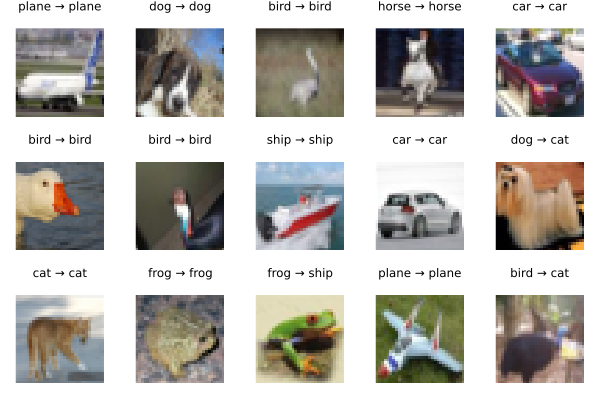

In [17]:
using Images, ImageShow, Plots

preds = Flux.onecold(model_small_convnet(X_test), 0:9)
trues = Flux.onecold(Y_test,      0:9)

function show_predictions(X, trues, preds; n=10)
    idxs = rand(1:size(X,4), n)
    cols = min(n,5); rows = ceil(Int,n/cols)
    plt = plot(layout=(rows,cols), margin=2Plots.mm, xticks=false, yticks=false)
    for (i,j) in enumerate(idxs)
        raw = X[:,:,:,j] |> cpu
        chw = permutedims(raw, (3,2,1))
        img = collect(colorview(RGB, chw))
        title = "$(classes[trues[j]+1]) → $(classes[preds[j]+1])"
        plot!(plt[i], img, seriestype=:heatmap,
              aspect_ratio=1, axis=false, title=title, titlefontsize=8)
    end
    display(plt)
end

show_predictions(X_test, trues, preds; n=15)

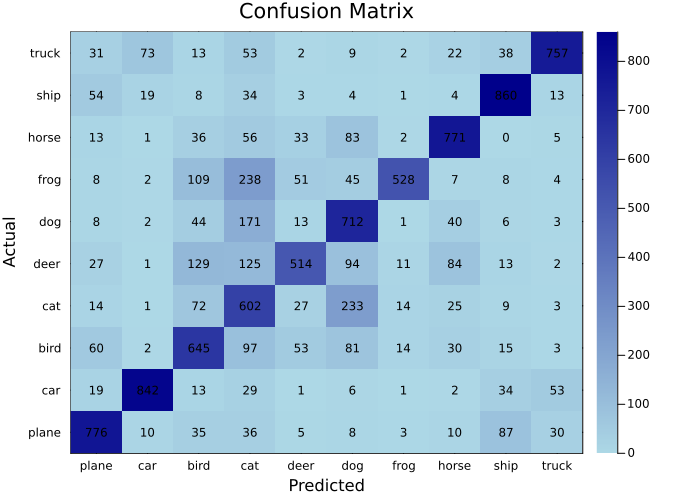

In [44]:
using Plots

cm = zeros(Int,10,10)
for (t,p) in zip(trues, preds)
    cm[t+1,p+1] += 1
end

xs = repeat(1:10, inner=10)
ys = repeat(1:10, outer=10)
txts = string.(vec(cm))

heatmap(
  cm;
  xticks        = (1:10, classes),
  yticks        = (1:10, classes),
  xlabel        = "Predicted",
  ylabel        = "Actual",
  title         = "Confusion Matrix",
  color         = :blues,
  right_margin  = 10Plots.mm,
  annotations   = (xs, ys, txts),
  annotationfontsize = 8,
  annotationfontcolor = :black,
  size          = (700,500),
  framestyle    = :box
)


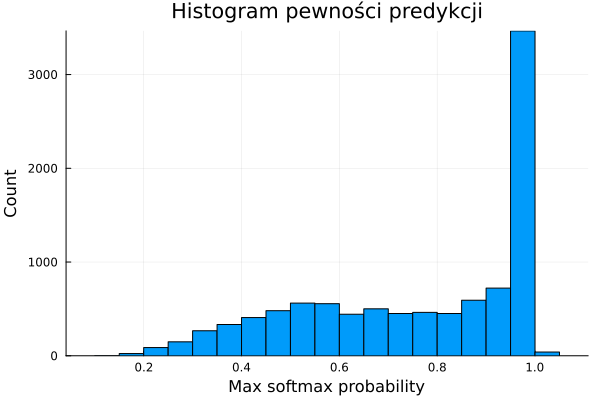

In [45]:
probs = maximum(model_small_convnet(X_test); dims=1)[:]   # max softmax over classes
histogram(
  probs,
  bins=20,
  xlabel="Max softmax probability",
  ylabel="Count",
  title="Histogram pewności predykcji",
  legend=false
)
